# Clustering to Produce Better Estimated Anchor Boxes Sizes and Ratios

In models like YOLO and Mask-RCNN and other object detection models, the term "anchor box" is a region that is proposed by the model in order to find objects within an image. These anchor boxes are generated given a set of suggested sizes and ratios that work for many use cases. But when it comes to squeezing out the last bit of accuracy from a model, it can be beneficial to fine tune this hyperparameter intelligently.

An incredible writeup on this topic can be found here: [Anchor Boxes — The key to quality object detection](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) by Towards Data Science.

In this notebook, I explore a custom dataset used in the [Ainascan](https://www.ainascan.com) project. This dataset is a collection of coffee crop images from all of the world and is used to attempt to train a model to segment leaves from the background. It is neatly organized into coco format so we can get the bounding boxes and segmentations quickly. We will attempt to fine tune the anchor box sizes and ratios for the Detectron2 model with the Mask-RCNN backbone.

In [3]:
import json

coco_data = json.load(open('coco.json'))

# we filter out only the leaf category
coco_data['annotations'] = [x for x in coco_data['annotations'] if x['category_id'] == 1]

print(f'Total number of annotations: {len(coco_data["annotations"])}')

Total number of annotations: 3321


We can start by examining the different width and heights of our annotations to see the distribution of sizes of our objects.

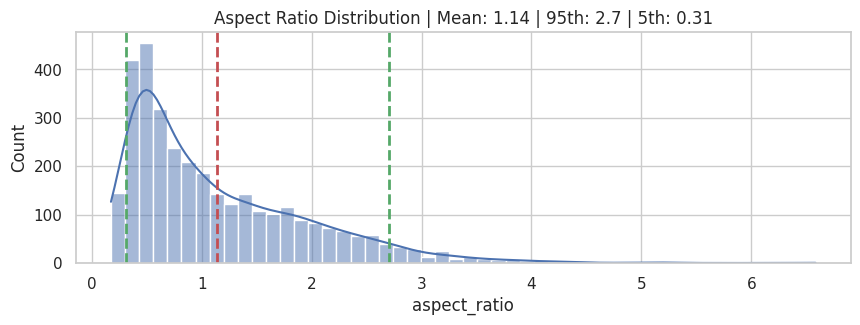

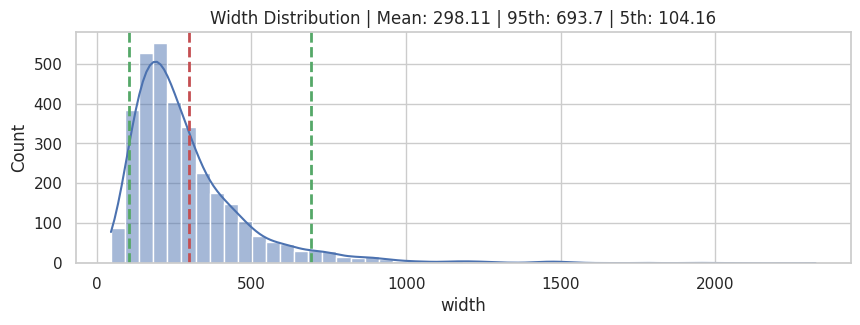

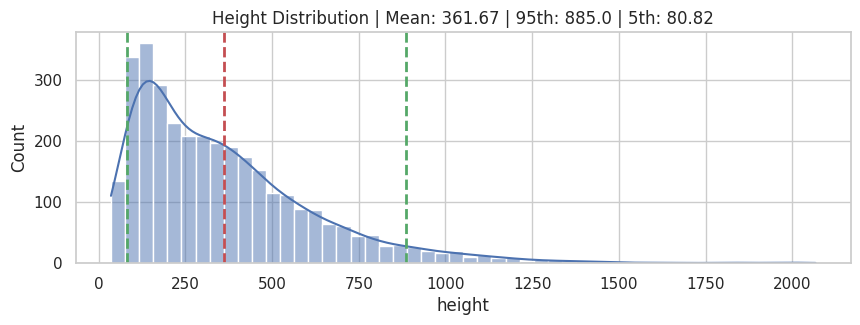

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='whitegrid')

df = []

for annotation in coco_data['annotations']:
    bbox = annotation['bbox']
    df.append({ 'width': bbox[2], 'height': bbox[3], 'aspect_ratio': bbox[2] / bbox[3] })

df = pd.DataFrame(df)


mean = df.aspect_ratio.mean()
percentile_95 = np.percentile(df.aspect_ratio, 95)
percentile_5 = np.percentile(df.aspect_ratio, 5)
plt.figure(figsize=(10, 3))
plt.title(f'Aspect Ratio Distribution | Mean: {round(mean, 2)} | 95th: {round(percentile_95, 2)} | 5th: {round(percentile_5, 2)}')
sns.histplot(df.aspect_ratio, bins=50, kde=True)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
plt.axvline(percentile_95, color='g', linestyle='dashed', linewidth=2)
plt.axvline(percentile_5, color='g', linestyle='dashed', linewidth=2)

mean = df.width.mean()
percentile_95 = np.percentile(df.width, 95)
percentile_5 = np.percentile(df.width, 5)
plt.figure(figsize=(10, 3))
plt.title(f'Width Distribution | Mean: {round(mean, 2)} | 95th: {round(percentile_95, 2)} | 5th: {round(percentile_5, 2)}')
sns.histplot(df.width, bins=50, kde=True)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
plt.axvline(percentile_95, color='g', linestyle='dashed', linewidth=2)
plt.axvline(percentile_5, color='g', linestyle='dashed', linewidth=2)

mean = df.height.mean()
percentile_95 = np.percentile(df.height, 95)
percentile_5 = np.percentile(df.height, 5)
plt.figure(figsize=(10, 3))
plt.title(f'Height Distribution | Mean: {round(mean, 2)} | 95th: {round(percentile_95, 2)} | 5th: {round(percentile_5, 2)}')
sns.histplot(df.height, bins=50, kde=True)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
plt.axvline(percentile_95, color='g', linestyle='dashed', linewidth=2)
plt.axvline(percentile_5, color='g', linestyle='dashed', linewidth=2)

As we can see, the distribution is quite skewed to the left, but are relatively large compared to the default anchor box sizes of Detectron2: 32, 64, 128, 256, 512. Certainly, default anchor boxes of aspect ratio 1 and sized 32 or 64 are too small for our dataset. Or at least, we can safely ignore them because they exist outside the 5th percentile of our dataset.

And at the 95th percentile, 512 may be too small to detect it. So we may want to consider larger anchor boxes.

Let's try a simple KMeans clustering to see if we can get a better idea of what anchor box sizes and ratios we should use. We will start with a density plot to try to visualize where the clusters might be.

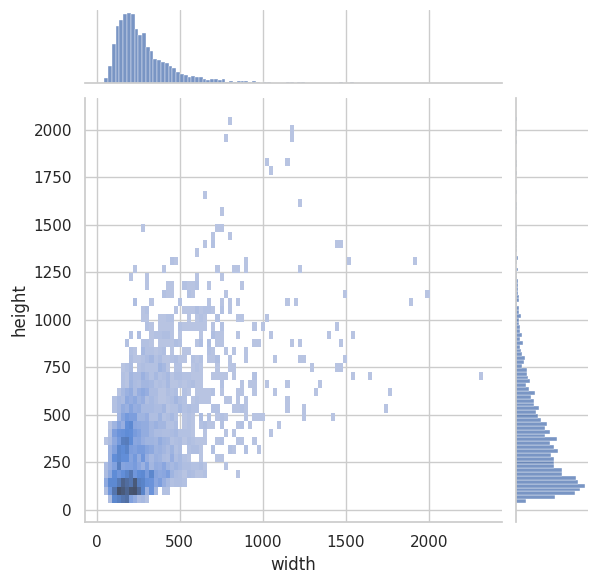

In [20]:
sns.jointplot(data=df, x='width', y='height', kind='hist', palette='viridis', marginal_kws=dict(bins=100, fill=True))

Immediately, we can see high density at the lower left corner, a small pocket just above it, and plenty of dispersion going towards the upper right. Somewhat intuitively, we might think to use 3 or 4 clusters to represent these different regions. But by doing so, with this much dispersion, we may end up with a cluster that is too large to be useful. We can pick and arbitrary number in this case to visualize how dispersed the clusters are.

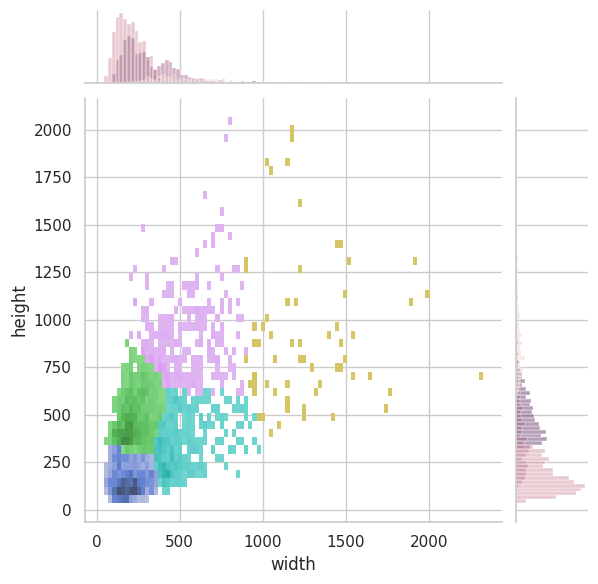

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

x = df[['width', 'height']]

pipeline = make_pipeline(StandardScaler(), KMeans(n_clusters=5))

df['cluster'] = pipeline.fit_predict(x)

sns.jointplot(
    data=df, 
    x='width',
    y='height',
    kind='hist',
    hue='cluster',
    palette='viridis',
    legend=False,
    marginal_kws=dict(bins=100, fill=True)
)